# SLT-CE-4: Constant Shift Embedding

In [ ]:
Legi 16-952-137

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [2]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import networkx as nx
import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [3]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [4]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [5]:
def D_from_S(S):
    """Produce D_ij = S_ii + S_jj - 2S_ij from S
    """
    diag = np.array([np.diag(S)]*np.shape(S)[0])
    return np.real(diag + diag.transpose() - 2 * S)

In [6]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.shortest_paths = None
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """
        ## IMPLEMENT THIS METHOD
        # Save data
        self.PMAT = PMAT       
        N = np.shape(PMAT)[0]
        # Create shortest_paths matrix
        G = nx.from_numpy_matrix(PMAT)
        paths = nx.shortest_path(G)
        shortest_paths = PMAT.copy()
        for i in range(N):
            for j in range(N):
                if paths[i].get(j) == None:
                    shortest_paths[i][j] = 10  # If there is no path between nodes 
                                               # (number to imput, > than graph diameter)
                else: 
                    shortest_paths[i][j] = len(paths[i][j]) - 1
        self.shortest_paths = shortest_paths
        # Data processing
        # Make sure that have zero diagonal
        for i in range(NUM_NODES):
            shortest_paths[i,i]=0 
        # Symmetrize (to be sure)
        D = 0.5 * (shortest_paths + np.transpose(shortest_paths))
        # Exponentiate distances
        #D = np.exp(-np.square(D))
        # Decompose, S_{ii} = 0
        S = -2 * D
        # Centralize
        Q = np.identity(N) - np.ones((N,N))/float(N)
        S_c = Q @ S @ Q       
        # Diagonal shift
        lambda_n = min(np.linalg.eigvals(S_c))
        S_tilda = S_c - lambda_n * np.identity(N)
        self.S = np.real(S_tilda)
        # Off-diagonal shift
        self.D = D_from_S(S_tilda)
        
    def get_embedded_vectors(self, p, n=0):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
            n (float): number of left eigenvalues if negative p is used. 
                       If n=0, then all are used
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        # Centralize
        N = np.shape(self.PMAT)[0]
        Q = np.identity(N) - np.ones((N,N))/float(N)
        S_c_tilda = -0.5 * Q @ self.D @ Q
        # SVD
        u, s, _ = np.linalg.svd(S_c_tilda)
        # Switch if need to use all or part of eigenvectors
        if p < 0 and not n:
            Xp = u * np.sqrt(s)
            return Xp
        elif p < 0:
            n_opt = n
        else:
            y = np.flip(np.sort(s))  # Sorted decreasing eigenvalues
            n_opt = np.count_nonzero(y > p)  
        Xp = u[:, 0:n_opt] * np.sqrt(s[0:n_opt])
        return Xp


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)

The model consists of data described as elements $x_i$ with some pairwise dissimilarities $D_{ij}$ on them ($D_{ii} = 0$), which could not satisfy distance properties. But introducing pairwise cost $$H^{\mathrm{pc}}=\frac{1}{2} \sum_{\nu=1}^{k} \frac{\sum_{i=1}^{n} \sum_{j=1}^{n} M_{i \nu} M_{j \nu} D_{i j}}{\sum_{l=1}^{n} M_{l \nu}}. $$ and using its proven _shift-invariance_ and _symmetrization_ properties elements $x_i$ can be transformed to the Euclidean space, such that in this space structure of clusters is preserved and the minimization of cost $H^{pc}$ in initial space is equivalent to minimization of k-means cost derived from $D_{ij}$.

**Algorithm**

Assuming $D_{ii} = 0$:
1. Symmetrization $\tilde{D}_{i j}=\frac{1}{2}\left(D_{i j}+D_{j i}\right)$
2. Decomposition - find $S$ s.t. $D_{i j}=S_{i i}+S_{j j}-2 S_{i j}$
3. Centralization $S^c = QSQ$, where $Q=I_n - \frac{1}{n}e_n e_n^\top$, $e_n=(\underbrace{1, \ldots, 1}_n)$ ($S\in\mathbb{R}_{n\times n}$)
4. Diagonal shift $\tilde{S} = S^c - \lambda_n(S^c)I_n$, where $\lambda_n(·)$ is the smallest eigenvalue
5. Off-diagonal shifted dissimilarities $\tilde{D}_{ij} = \tilde{S_{i i}}+\tilde{S_{j j}}-2 \tilde{S_{i j}} $ - squared Euclidean distances matrix
6. Cluster in Euclidean space using conventional algorithm (e.g. $k$-means) with $\tilde{D}$.

<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [7]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [8]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

[ 4.48770248e+02  3.84590309e+02  3.38642512e+02 ...  5.60722663e+01
  5.08638388e+01 -1.02318154e-12]
check symmetry of S True
check zero imaginary parts of eigenvalues: True


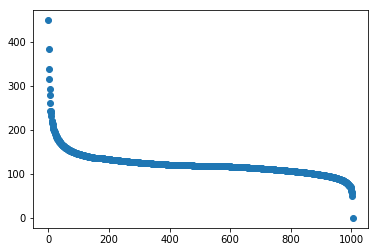

In [9]:
%matplotlib inline
## Compute eigen-spectrum
eigs = np.linalg.eigvals(CSE.S)
y = np.flip(np.sort(np.real(eigs)))
print(y)
print("check symmetry of S {}".format(
    np.isclose(0, np.linalg.norm(CSE.S - np.transpose(CSE.S)))))
print("check zero imaginary parts of eigenvalues: {}".format(
    np.isclose(0, np.sum(np.abs(np.imag(eigs))))))
x = tuple(range(len(y)))
plt.scatter(x, y)
plt.show(x, y)

In [10]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 180## change accordingly
print("Chosen cut-off value is: ", p_opt)
n_opt = np.count_nonzero(y > p_opt)
print("Components: ", n_opt)

Chosen cut-off value is:  180
Components:  31


Value is chosen at the place where decrease of magnitude of eigenvalues is drastically
slowed, but the number of these eigenvalues is relatively small yet

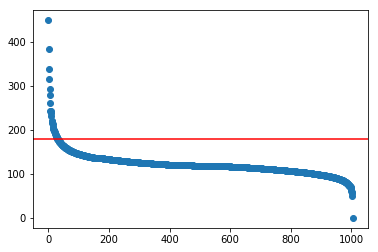

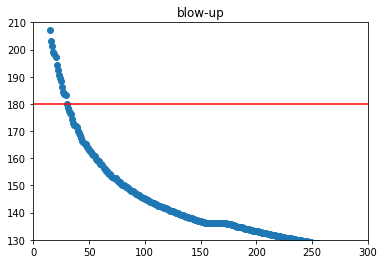

In [11]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.scatter(x, y)
plt.axhline(y=p_opt, color='r', linestyle='-')
plt.show(x, y)
plt.title("blow-up")
plt.ylim(130,210)
plt.xlim(0, 300)
plt.scatter(x, y)
plt.axhline(y=p_opt, color='r', linestyle='-')
plt.show(x, y)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [12]:
!pip install --upgrade pip
!pip install seaborn --quiet

Requirement already up-to-date: pip in /home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages (20.1)


In [13]:
def permute_matrix(M, p):
    N = M.copy()
    N[:,:] = M[p,:]
    N[:,:] = M[:,p]
    return N

<Figure size 432x288 with 0 Axes>

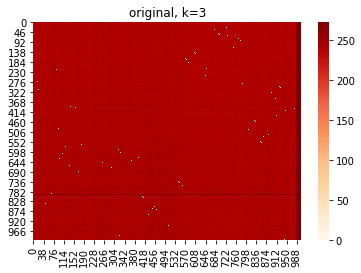

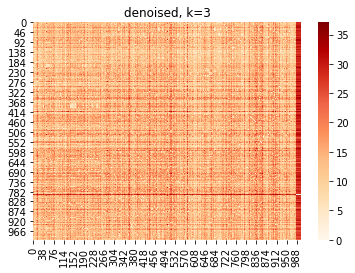

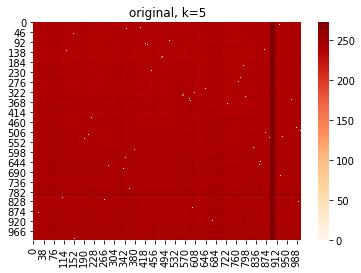

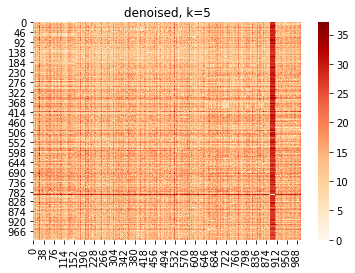

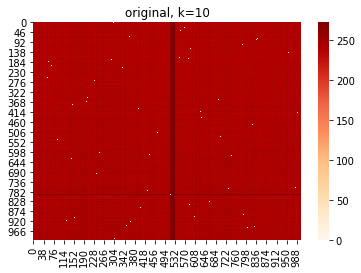

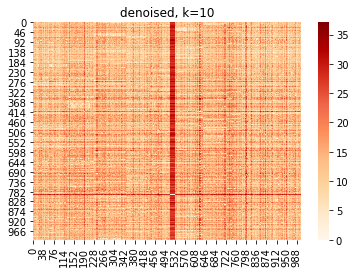

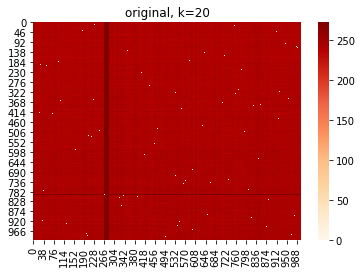

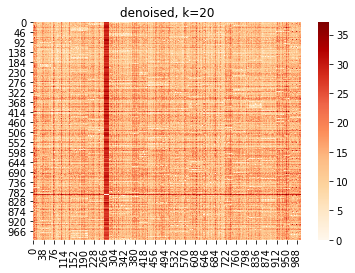

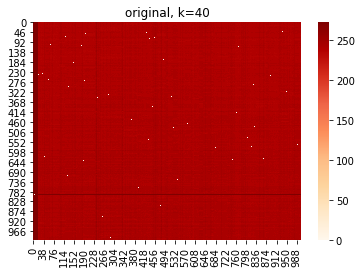

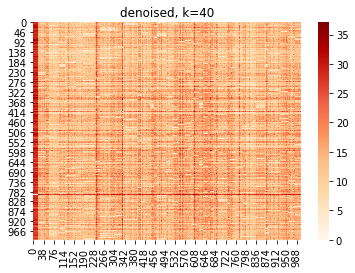

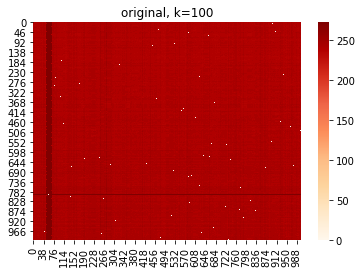

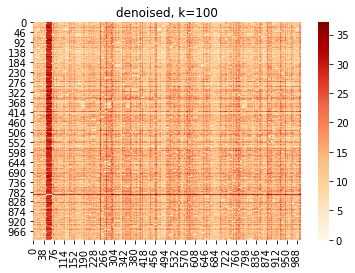

In [14]:
%matplotlib inline
## Distance matrices
import seaborn as sns
import sklearn

Xp = CSE.get_embedded_vectors(p_opt)
Sp = Xp @ (Xp.transpose())
Dp = D_from_S(Sp)
fig = plt.figure()
for ind, k in enumerate([3, 5, 10, 20, 40, 100]):
    kmeans = KMeans(n_clusters=k, n_init=100).fit(Xp)
    labels = kmeans.labels_
    hist, bins=np.histogram(labels, bins=np.linspace(0,k,k))
    perm = np.argsort(labels)
    Dp_denoised = permute_matrix(Dp, perm)
    D_orig = permute_matrix(CSE.D, perm)
    plt.figure()
    plt.title("original, k={}".format(k))
    sns.heatmap(
        D_orig,
        cmap='OrRd',
    )
    plt.figure()
    plt.title("denoised, k={}".format(k))
    sns.heatmap(
        Dp_denoised,
        cmap='OrRd',
    );

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [14]:
## Get embeddings, run K-MEANS and generate plots

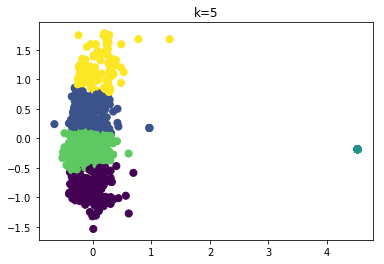

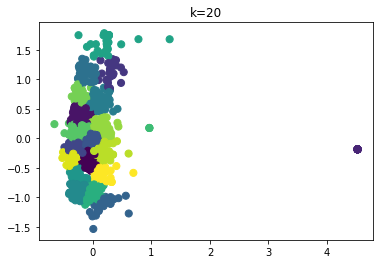

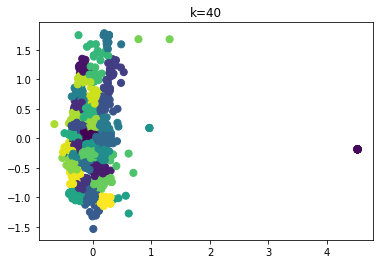

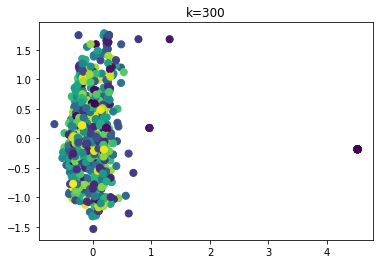

In [15]:
## p = 2
X2 = CSE.get_embedded_vectors(-1, n=2)
for k in (5, 20, 40, 300):
    kmeans = KMeans(n_clusters=k).fit(X2)
    fig = plt.figure()
    plt.title("k={}".format(k))
    plt.scatter(X2[:, 0], X2[:, 1], c=kmeans.labels_, s=50, cmap='viridis')

/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


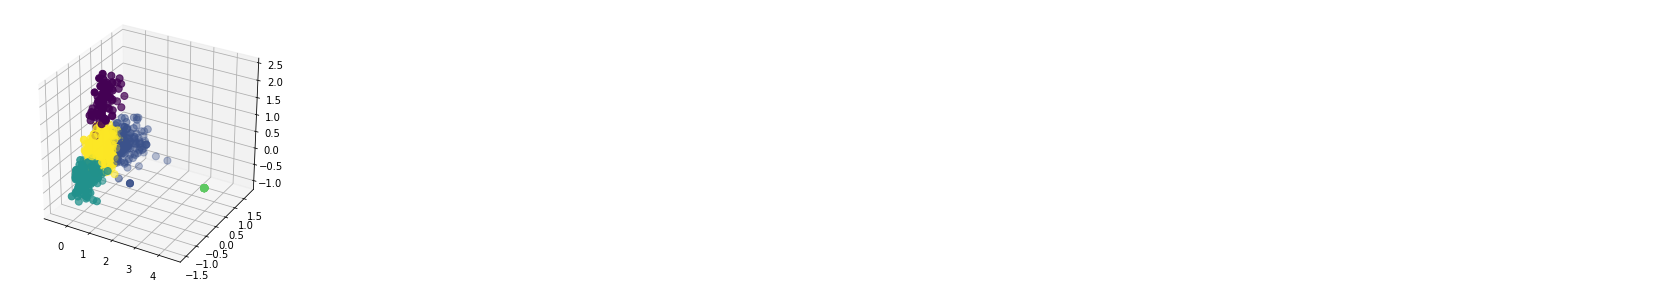

/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


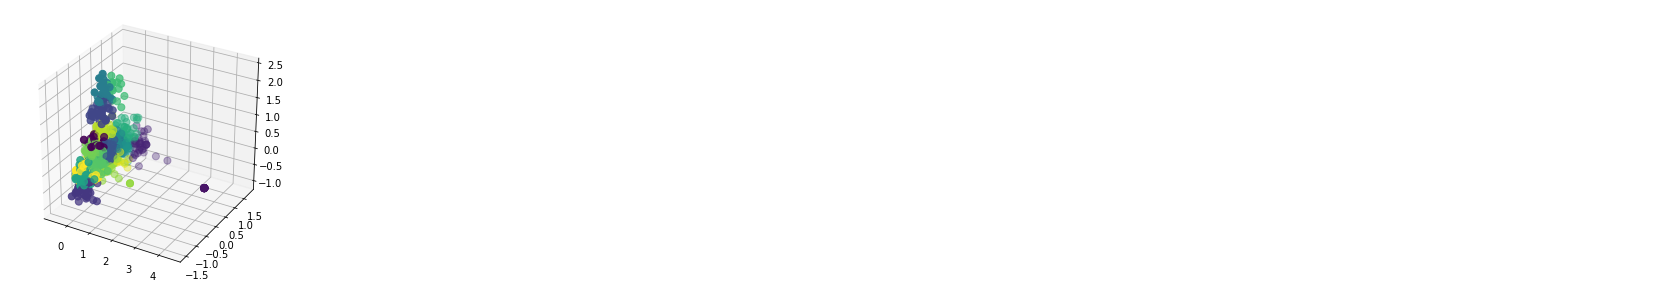

/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


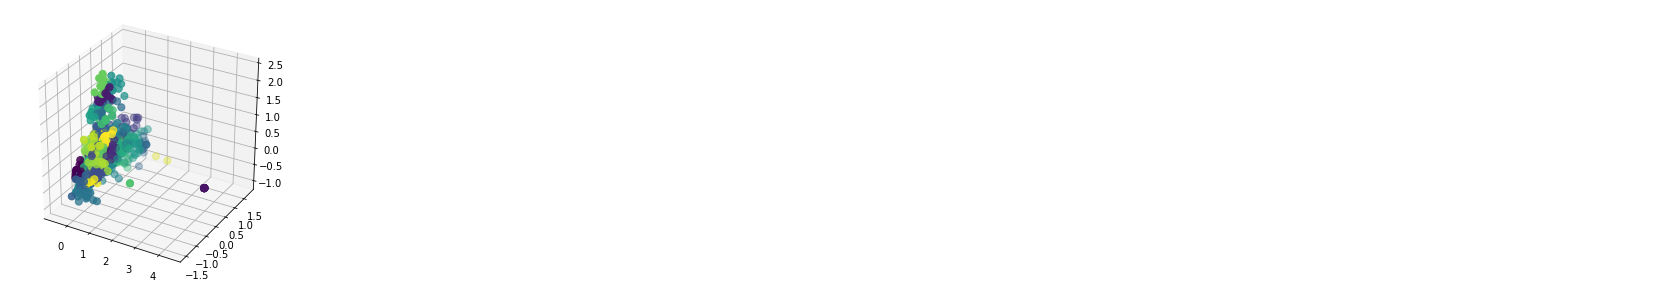

/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


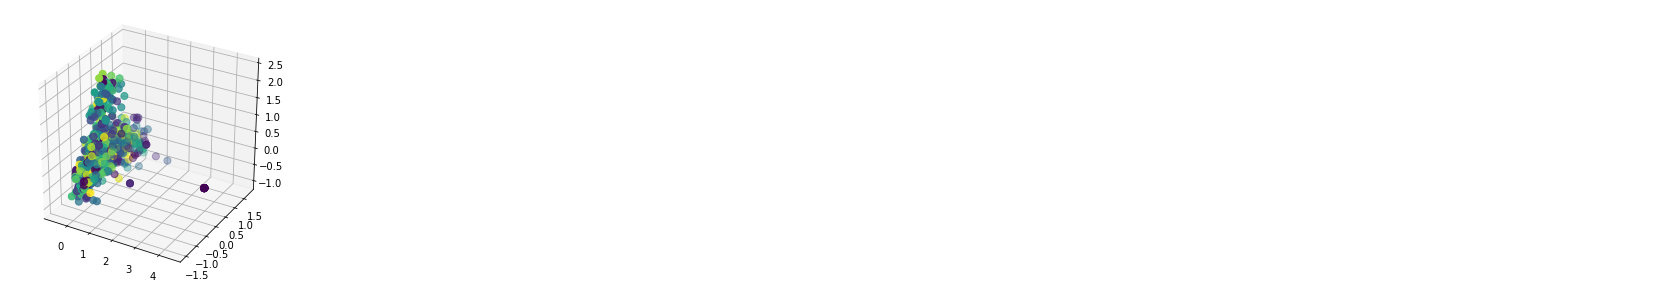

In [16]:
%matplotlib inline
## p = 3
X2 = CSE.get_embedded_vectors(-1, n=3)
for k in (5, 20, 40, 300):
    kmeans = KMeans(n_clusters=k).fit(X2)
    fig = plt.figure(figsize=(5,5))
    plt.title("k={}".format(k))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2], c=kmeans.labels_, s=50, cmap='viridis')
    plt.show()

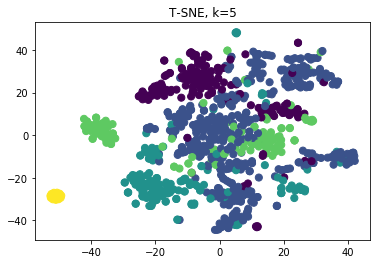

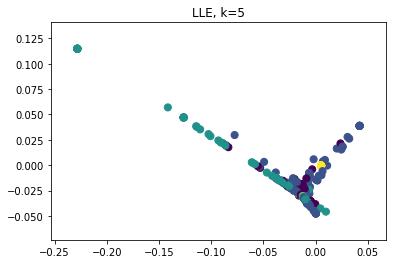

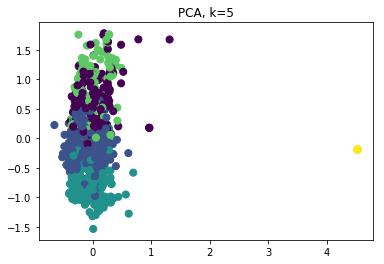

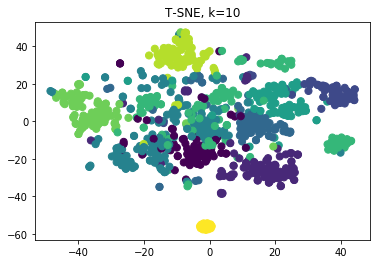

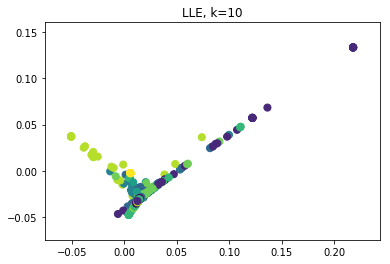

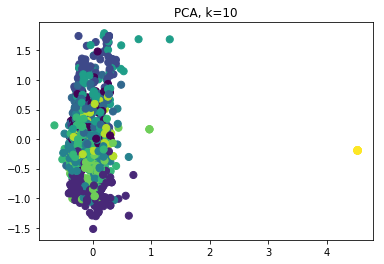

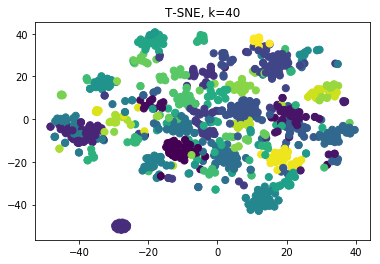

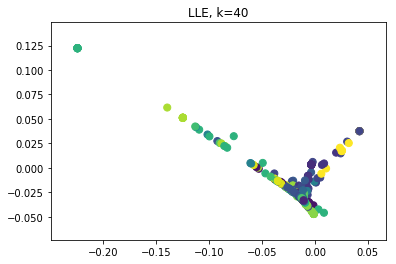

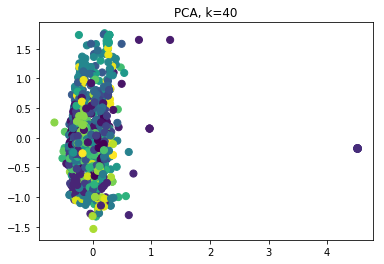

In [17]:
## choose p > 3, for example, p = p_opt 
## clusted computed p-dimentional embeddings and project them onto 2-dimensional space for visualization
## using PCA, LL, t-SNE or something else
Xp = CSE.get_embedded_vectors(p_opt)
for k in (5,10,40):
    kmeans = KMeans(n_clusters=k).fit(Xp)
    
    X_tr_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(Xp)
    fig = plt.figure()
    plt.title("T-SNE, k={}".format(k))
    plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
    
    X_tr_lle = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2).fit_transform(Xp)
    fig = plt.figure()
    plt.title("LLE, k={}".format(k))
    plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
    
    X_tr_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(Xp)
    fig = plt.figure()
    plt.title("PCA, k={}".format(k))
    plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=kmeans.labels_, s=50, cmap='viridis')

Probably, T-SNE seems to be the most adequate with demostrating some structure behind

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [18]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

Metrics from here https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [19]:
from sklearn import metrics
Xp = CSE.get_embedded_vectors(p_opt)
Sp = Xp @ (Xp.transpose())
Dp = D_from_S(Sp)
kmeans = KMeans(n_clusters=len(np.unique(AFFILIATIONS))).fit(Xp)
labels = kmeans.labels_
print("Labeling quality metric (0 - random, 1 - perfect): \n{}".format(
    metrics.adjusted_rand_score(AFFILIATIONS, labels))) # almost random labeling if close to 0
print("Labeling quality metric (<0 - random, 1 - perfect): \n{}".format(
    metrics.adjusted_mutual_info_score(AFFILIATIONS, labels)))

Labeling quality metric (0 - random, 1 - perfect): 
0.4062971307720976
Labeling quality metric (<0 - random, 1 - perfect): 
0.5201741297196801


/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Please, write here your explanations, observation and thoughts about results of the experiments above.

I tried to use as initial $D$ plain adjacency matrix, just shortest paths matrix (as used here) and also exponentiated minus square shortest paths matrix (like diffusion). Nevertheless, it's hard to see any structure in the data, as eigenvalues of the resulting $S$ don't decrease very rapidly (as in [1]), which doesn't allow as to find good denoising threshold (I tried to increase and decrease it, but still structure isn't visible clearly)

Overall, it seems that the data is hard to cluster or there is some mistake in the code, which prevents having good results

In [62]:
def f(n,d):
    if n:
        return 1.0/d+(d-1.0)/d*f(n-1,d)
    else:
        return 1.0/d

In [72]:
for d in (5000,):
    print(d/(d+0.1)*f(d-1,d))

RecursionError: maximum recursion depth exceeded

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.